In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_32_02 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.2
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_32_02[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 61.755836963653564 
    loop_MC 1 - time has passed: 116.7217264175415 
    loop_MC 2 - time has passed: 187.27178692817688 
    loop_MC 3 - time has passed: 258.5362572669983 
    loop_MC 4 - time has passed: 318.0443217754364 
    loop_MC 5 - time has passed: 365.44302773475647 
    loop_MC 6 - time has passed: 427.02274799346924 
    loop_MC 7 - time has passed: 484.72550988197327 
    loop_MC 8 - time has passed: 551.9105415344238 
    loop_MC 9 - time has passed: 601.9448492527008 
    loop_MC 10 - time has passed: 660.7760450839996 
    loop_MC 11 - time has passed: 719.68692278862 
    loop_MC 12 - time has passed: 788.5214130878448 
    loop_MC 13 - time has passed: 845.9237954616547 
    loop_MC 14 - time has passed: 910.0530025959015 
    loop_MC 15 - time has passed: 974.0510172843933 
    loop_MC 16 - time has passed: 1035.9889256954193 
    loop_MC 17 - time has passed: 1096.1224751472473 
    loop_MC 18 - time has passed: 1153.346374988556

    loop_MC 2 - time has passed: 172.88205790519714 
    loop_MC 3 - time has passed: 224.42674112319946 
    loop_MC 4 - time has passed: 285.83408308029175 
    loop_MC 5 - time has passed: 349.3345727920532 
    loop_MC 6 - time has passed: 396.3221936225891 
    loop_MC 7 - time has passed: 461.5767238140106 
    loop_MC 8 - time has passed: 521.7628059387207 
    loop_MC 9 - time has passed: 573.3647272586823 
    loop_MC 10 - time has passed: 620.5562736988068 
    loop_MC 11 - time has passed: 677.5966970920563 
    loop_MC 12 - time has passed: 723.6216897964478 
    loop_MC 13 - time has passed: 776.4930090904236 
    loop_MC 14 - time has passed: 821.5806930065155 
    loop_MC 15 - time has passed: 878.0125539302826 
    loop_MC 16 - time has passed: 926.0174894332886 
    loop_MC 17 - time has passed: 982.9524793624878 
    loop_MC 18 - time has passed: 1034.3121168613434 
    loop_MC 19 - time has passed: 1087.69078207016 
    loop_MC 20 - time has passed: 1138.785012960434

    loop_MC 4 - time has passed: 256.7953848838806 
    loop_MC 5 - time has passed: 306.1787004470825 
    loop_MC 6 - time has passed: 354.2610013484955 
    loop_MC 7 - time has passed: 408.1277928352356 
    loop_MC 8 - time has passed: 456.50654220581055 
    loop_MC 9 - time has passed: 512.6663174629211 
    loop_MC 10 - time has passed: 557.2204222679138 
    loop_MC 11 - time has passed: 610.5588726997375 
    loop_MC 12 - time has passed: 671.140495300293 
    loop_MC 13 - time has passed: 722.6631379127502 
    loop_MC 14 - time has passed: 774.3840134143829 
    loop_MC 15 - time has passed: 827.8484792709351 
    loop_MC 16 - time has passed: 883.691823720932 
    loop_MC 17 - time has passed: 941.707377910614 
    loop_MC 18 - time has passed: 989.7239437103271 
    loop_MC 19 - time has passed: 1044.6364998817444 
    loop_MC 20 - time has passed: 1096.985193014145 
    loop_MC 21 - time has passed: 1153.1904892921448 
    loop_MC 22 - time has passed: 1195.973887681961 

    loop_MC 6 - time has passed: 337.1174774169922 
    loop_MC 7 - time has passed: 382.58875584602356 
    loop_MC 8 - time has passed: 434.90521812438965 
    loop_MC 9 - time has passed: 494.2523138523102 
    loop_MC 10 - time has passed: 549.7249765396118 
    loop_MC 11 - time has passed: 603.9099233150482 
    loop_MC 12 - time has passed: 666.3044171333313 
    loop_MC 13 - time has passed: 714.6416163444519 
    loop_MC 14 - time has passed: 759.1348767280579 
    loop_MC 15 - time has passed: 806.2320129871368 
    loop_MC 16 - time has passed: 851.116327047348 
    loop_MC 17 - time has passed: 904.0130093097687 
    loop_MC 18 - time has passed: 958.1985499858856 
    loop_MC 19 - time has passed: 1001.0707318782806 
    loop_MC 20 - time has passed: 1059.8656668663025 
    loop_MC 21 - time has passed: 1104.9757137298584 
    loop_MC 22 - time has passed: 1149.8042123317719 
    loop_MC 23 - time has passed: 1200.6622502803802 
    loop_MC 24 - time has passed: 1253.64488

    loop_MC 8 - time has passed: 460.3860242366791 
    loop_MC 9 - time has passed: 502.1646673679352 
    loop_MC 10 - time has passed: 556.195335149765 
    loop_MC 11 - time has passed: 599.0983927249908 
    loop_MC 12 - time has passed: 642.7795369625092 
    loop_MC 13 - time has passed: 694.2520189285278 
    loop_MC 14 - time has passed: 744.2770166397095 
    loop_MC 15 - time has passed: 793.1943814754486 
    loop_MC 16 - time has passed: 840.6006717681885 
    loop_MC 17 - time has passed: 882.0990426540375 
    loop_MC 18 - time has passed: 932.3069701194763 
    loop_MC 19 - time has passed: 980.7383506298065 
    loop_MC 20 - time has passed: 1024.9536519050598 
    loop_MC 21 - time has passed: 1068.9255986213684 
    loop_MC 22 - time has passed: 1116.4272773265839 
    loop_MC 23 - time has passed: 1157.938726425171 
    loop_MC 24 - time has passed: 1213.1228382587433 
    loop_MC 25 - time has passed: 1261.8087747097015 
    loop_MC 26 - time has passed: 1301.48892

    loop_MC 10 - time has passed: 500.45349502563477 
    loop_MC 11 - time has passed: 556.4961867332458 
    loop_MC 12 - time has passed: 601.0019257068634 
    loop_MC 13 - time has passed: 654.6191921234131 
    loop_MC 14 - time has passed: 696.2561318874359 
    loop_MC 15 - time has passed: 748.9609377384186 
    loop_MC 16 - time has passed: 803.1599760055542 
    loop_MC 17 - time has passed: 850.2773544788361 
    loop_MC 18 - time has passed: 899.3432960510254 
    loop_MC 19 - time has passed: 948.8811511993408 
    loop_MC 20 - time has passed: 997.3931703567505 
    loop_MC 21 - time has passed: 1043.9958941936493 
    loop_MC 22 - time has passed: 1083.4041426181793 
    loop_MC 23 - time has passed: 1135.0675003528595 
    loop_MC 24 - time has passed: 1185.9747416973114 
    loop_MC 25 - time has passed: 1240.3311655521393 
    loop_MC 26 - time has passed: 1281.9255981445312 
    loop_MC 27 - time has passed: 1337.2177956104279 
    loop_MC 28 - time has passed: 1391

    loop_MC 12 - time has passed: 594.7772252559662 
    loop_MC 13 - time has passed: 643.3964426517487 
    loop_MC 14 - time has passed: 679.7138855457306 
    loop_MC 15 - time has passed: 725.3073964118958 
    loop_MC 16 - time has passed: 777.8700978755951 
    loop_MC 17 - time has passed: 827.3753232955933 
    loop_MC 18 - time has passed: 877.9974272251129 
    loop_MC 19 - time has passed: 924.8620886802673 
    loop_MC 20 - time has passed: 961.1644475460052 
    loop_MC 21 - time has passed: 1013.4689729213715 
    loop_MC 22 - time has passed: 1065.522922039032 
    loop_MC 23 - time has passed: 1103.863318681717 
    loop_MC 24 - time has passed: 1156.5560493469238 
    loop_MC 25 - time has passed: 1198.1252665519714 
    loop_MC 26 - time has passed: 1243.8741147518158 
    loop_MC 27 - time has passed: 1291.3122279644012 
    loop_MC 28 - time has passed: 1337.5510687828064 
    loop_MC 29 - time has passed: 1381.0003769397736 
    loop_MC 30 - time has passed: 1441.

    loop_MC 14 - time has passed: 704.8600986003876 
    loop_MC 15 - time has passed: 753.5685069561005 
    loop_MC 16 - time has passed: 803.1275594234467 
    loop_MC 17 - time has passed: 848.8927412033081 
    loop_MC 18 - time has passed: 913.232771396637 
    loop_MC 19 - time has passed: 955.4125370979309 
    loop_MC 20 - time has passed: 997.9505681991577 
    loop_MC 21 - time has passed: 1036.6328239440918 
    loop_MC 22 - time has passed: 1076.6627810001373 
    loop_MC 23 - time has passed: 1127.891564130783 
    loop_MC 24 - time has passed: 1170.2972009181976 
    loop_MC 25 - time has passed: 1216.8406887054443 
    loop_MC 26 - time has passed: 1257.991801738739 
    loop_MC 27 - time has passed: 1310.189889907837 
    loop_MC 28 - time has passed: 1361.7443647384644 
    loop_MC 29 - time has passed: 1405.6058275699615 
    loop_MC 30 - time has passed: 1453.5198395252228 
    loop_MC 31 - time has passed: 1496.250503540039 
    loop_MC 32 - time has passed: 1548.1

    loop_MC 16 - time has passed: 730.3445386886597 
    loop_MC 17 - time has passed: 778.7209916114807 
    loop_MC 18 - time has passed: 825.6764953136444 
    loop_MC 19 - time has passed: 868.2676944732666 
    loop_MC 20 - time has passed: 911.9342896938324 
    loop_MC 21 - time has passed: 954.1175014972687 
    loop_MC 22 - time has passed: 1003.2345895767212 
    loop_MC 23 - time has passed: 1050.510047674179 
    loop_MC 24 - time has passed: 1096.785621881485 
    loop_MC 25 - time has passed: 1141.175113916397 
    loop_MC 26 - time has passed: 1184.9752492904663 
    loop_MC 27 - time has passed: 1228.0931313037872 
    loop_MC 28 - time has passed: 1273.085047006607 
    loop_MC 29 - time has passed: 1321.037758588791 
    loop_MC 30 - time has passed: 1367.8105852603912 
    loop_MC 31 - time has passed: 1413.279087305069 
    loop_MC 32 - time has passed: 1461.255368232727 
    loop_MC 33 - time has passed: 1508.2705404758453 
    loop_MC 34 - time has passed: 1551.99

    loop_MC 18 - time has passed: 811.8969871997833 
    loop_MC 19 - time has passed: 862.8297777175903 
    loop_MC 20 - time has passed: 900.6593909263611 
    loop_MC 21 - time has passed: 946.4038276672363 
    loop_MC 22 - time has passed: 984.5157959461212 
    loop_MC 23 - time has passed: 1031.309089422226 
    loop_MC 24 - time has passed: 1074.389080286026 
    loop_MC 25 - time has passed: 1112.4090449810028 
    loop_MC 26 - time has passed: 1161.025619983673 
    loop_MC 27 - time has passed: 1196.2167792320251 
    loop_MC 28 - time has passed: 1231.4707698822021 
    loop_MC 29 - time has passed: 1267.3852429389954 
    loop_MC 30 - time has passed: 1313.708987236023 
    loop_MC 31 - time has passed: 1363.384377002716 
    loop_MC 32 - time has passed: 1401.1357777118683 
    loop_MC 33 - time has passed: 1443.3545701503754 
    loop_MC 34 - time has passed: 1484.4662926197052 
    loop_MC 35 - time has passed: 1522.5333137512207 
    loop_MC 36 - time has passed: 1565

    loop_MC 20 - time has passed: 853.2168576717377 
    loop_MC 21 - time has passed: 891.3596522808075 
    loop_MC 22 - time has passed: 936.1482443809509 
    loop_MC 23 - time has passed: 976.8607687950134 
    loop_MC 24 - time has passed: 1013.3147926330566 
    loop_MC 25 - time has passed: 1054.132227897644 
    loop_MC 26 - time has passed: 1091.736599445343 
    loop_MC 27 - time has passed: 1134.2642936706543 
    loop_MC 28 - time has passed: 1177.9973385334015 
    loop_MC 29 - time has passed: 1225.1061096191406 
    loop_MC 30 - time has passed: 1259.555053949356 
    loop_MC 31 - time has passed: 1297.4599058628082 
    loop_MC 32 - time has passed: 1342.8684375286102 
    loop_MC 33 - time has passed: 1378.9412133693695 
    loop_MC 34 - time has passed: 1420.241229057312 
    loop_MC 35 - time has passed: 1469.1966927051544 
    loop_MC 36 - time has passed: 1514.05579662323 
    loop_MC 37 - time has passed: 1555.2187016010284 
    loop_MC 38 - time has passed: 1597

    loop_MC 22 - time has passed: 994.0648052692413 
    loop_MC 23 - time has passed: 1038.7017905712128 
    loop_MC 24 - time has passed: 1079.8516793251038 
    loop_MC 25 - time has passed: 1124.1688768863678 
    loop_MC 26 - time has passed: 1159.0136544704437 
    loop_MC 27 - time has passed: 1208.920859336853 
    loop_MC 28 - time has passed: 1249.6921122074127 
    loop_MC 29 - time has passed: 1289.9065148830414 
    loop_MC 30 - time has passed: 1335.0873687267303 
    loop_MC 31 - time has passed: 1376.5726330280304 
    loop_MC 32 - time has passed: 1421.3178021907806 
    loop_MC 33 - time has passed: 1457.9429285526276 
    loop_MC 34 - time has passed: 1495.7219698429108 
    loop_MC 35 - time has passed: 1534.1838822364807 
    loop_MC 36 - time has passed: 1571.848804473877 
    loop_MC 37 - time has passed: 1612.8462822437286 
    loop_MC 38 - time has passed: 1654.1518807411194 
    loop_MC 39 - time has passed: 1688.3199422359467 
    loop_MC 40 - time has passe

    loop_MC 24 - time has passed: 1065.1504213809967 
    loop_MC 25 - time has passed: 1113.9108448028564 
    loop_MC 26 - time has passed: 1161.3020610809326 
    loop_MC 27 - time has passed: 1203.0062894821167 
    loop_MC 28 - time has passed: 1252.1077916622162 
    loop_MC 29 - time has passed: 1291.8220148086548 
    loop_MC 30 - time has passed: 1329.2777802944183 
    loop_MC 31 - time has passed: 1364.210299730301 
    loop_MC 32 - time has passed: 1409.9739787578583 
    loop_MC 33 - time has passed: 1448.1694900989532 
    loop_MC 34 - time has passed: 1482.47243642807 
    loop_MC 35 - time has passed: 1523.3536932468414 
    loop_MC 36 - time has passed: 1562.0527260303497 
    loop_MC 37 - time has passed: 1604.4406049251556 
    loop_MC 38 - time has passed: 1640.943559885025 
    loop_MC 39 - time has passed: 1675.8519294261932 
    loop_MC 40 - time has passed: 1725.0166137218475 
    loop_MC 41 - time has passed: 1770.0505900382996 
    loop_MC 42 - time has passed

    loop_MC 26 - time has passed: 1107.8168749809265 
    loop_MC 27 - time has passed: 1157.0504097938538 
    loop_MC 28 - time has passed: 1198.6374380588531 
    loop_MC 29 - time has passed: 1238.315318107605 
    loop_MC 30 - time has passed: 1278.7124860286713 
    loop_MC 31 - time has passed: 1319.4059505462646 
    loop_MC 32 - time has passed: 1358.429680109024 
    loop_MC 33 - time has passed: 1393.9626235961914 
    loop_MC 34 - time has passed: 1433.2183468341827 
    loop_MC 35 - time has passed: 1479.0291829109192 
    loop_MC 36 - time has passed: 1521.4103763103485 
    loop_MC 37 - time has passed: 1570.1679227352142 
    loop_MC 38 - time has passed: 1608.7125129699707 
    loop_MC 39 - time has passed: 1642.3645269870758 
    loop_MC 40 - time has passed: 1694.989996433258 
    loop_MC 41 - time has passed: 1738.7462348937988 
    loop_MC 42 - time has passed: 1785.7301905155182 
    loop_MC 43 - time has passed: 1826.1611926555634 
    loop_MC 44 - time has passe

    loop_MC 28 - time has passed: 1222.8480916023254 
    loop_MC 29 - time has passed: 1263.9503264427185 
    loop_MC 30 - time has passed: 1312.3526780605316 
    loop_MC 31 - time has passed: 1350.612441778183 
    loop_MC 32 - time has passed: 1398.0175111293793 
    loop_MC 33 - time has passed: 1441.0773780345917 
    loop_MC 34 - time has passed: 1492.2436048984528 
    loop_MC 35 - time has passed: 1535.1228518486023 
    loop_MC 36 - time has passed: 1569.7012691497803 
    loop_MC 37 - time has passed: 1606.7013926506042 
    loop_MC 38 - time has passed: 1644.7418110370636 
    loop_MC 39 - time has passed: 1688.7553629875183 
    loop_MC 40 - time has passed: 1725.71054148674 
    loop_MC 41 - time has passed: 1768.5456149578094 
    loop_MC 42 - time has passed: 1809.994777917862 
    loop_MC 43 - time has passed: 1850.6038854122162 
    loop_MC 44 - time has passed: 1898.7676367759705 
    loop_MC 45 - time has passed: 1938.460834980011 
    loop_MC 46 - time has passed:

    loop_MC 30 - time has passed: 1299.2992570400238 
    loop_MC 31 - time has passed: 1348.5880091190338 
    loop_MC 32 - time has passed: 1392.6758017539978 
    loop_MC 33 - time has passed: 1442.1990439891815 
    loop_MC 34 - time has passed: 1486.7073948383331 
    loop_MC 35 - time has passed: 1535.390836238861 
    loop_MC 36 - time has passed: 1583.933720111847 
    loop_MC 37 - time has passed: 1624.7845923900604 
    loop_MC 38 - time has passed: 1670.7366576194763 
    loop_MC 39 - time has passed: 1716.8221848011017 
    loop_MC 40 - time has passed: 1760.0452930927277 
    loop_MC 41 - time has passed: 1807.7348339557648 
    loop_MC 42 - time has passed: 1842.320110797882 
    loop_MC 43 - time has passed: 1882.6663599014282 
    loop_MC 44 - time has passed: 1930.584144115448 
    loop_MC 45 - time has passed: 1965.3973145484924 
    loop_MC 46 - time has passed: 2013.0918080806732 
    loop_MC 47 - time has passed: 2061.2901928424835 
    loop_MC 48 - time has passed

In [6]:
print(i_beta_32_02)

[0.06592 0.08075 0.19557 0.22618 0.24945 0.29303 0.37196 0.39916 0.37109
 0.43371 0.46384 0.44285 0.5323  0.487   0.55593 0.53884 0.56258 0.51067
 0.58636 0.59685 0.60627 0.59698 0.62484 0.64282 0.65006 0.63708 0.64141
 0.65796 0.66111 0.66665 0.66794 0.67007 0.67233 0.67744 0.67937 0.67979
 0.68326 0.68458 0.68482 0.68516 0.68622 0.68858 0.68924 0.69239 0.6934
 0.69489]


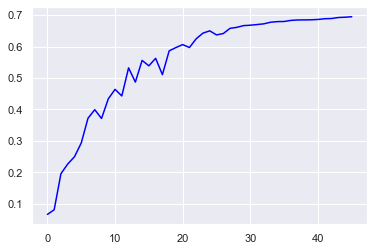

In [7]:
plt.plot(i_beta_32_02, color='blue')

In [8]:
scio.savemat('./i_beta_32_02.mat', {'i_beta_32_02': i_beta_32_02})